# SMAI Assignment - 2

## Question 2: Gaussian Mixture Models

Resources:
- https://youtu.be/qMTuMa86NzU
- https://youtu.be/ZBLyXgjBx3Q

Reference: https://scikit-learn.org/stable/modules/mixture.html

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Part 1: Gaussian Mixture Models

We'll attempt to solve the task of background subtraction using Gaussian Mixture Models. Before that, you will need to implement the Gaussian Mixture Model algorithm from scratch.

Some details:
- Try to implement GMMs using Multi-variate Gaussian Distributions, the following tasks in the assignment are possible to implement using the Univariate version too but it might be bit inaccurate as explained below.
    - To clarify further, we could treat each pixel in our RGB image as our data point with [R, G, B] channels as the dimensions to the Multi-variate data point, and we would easily get predictions for each pixel location using Multi-variate approach.
    - Or, we could treat every single value in the given RGB image as a data point independent of what channel the belong to and consider them as Uni-variate data point, and get prediction using the Uni-variate approach.
    But this affects our prediction, since we can't simply make per pixel predtions anymore, because for every pixel location we would now have 3 different predictions.
    - To get around this, you could convert your image to Grayscale and then we would only have one channel/value corresponding to each pixel location, which would now allow us to use the Uni-variate approach for prediction, but this also means loss in information which would affect our quality of predictions.
    - Try to have a class based implementation of GMM, this would really help you in Background Subtraction task. You can get some general ideas on how to structure your class by looking at `sklearn.mixture.GaussianMixture` documentation and source code.
- The following code cell has a rough template to get you started with the implementation. You are free to change the structure of the code, this is just a suggestion to help you get started.


TLDR: You may implement the univariate version of GMMs, but it might not be as accurate as the multivariate version and it is recommended to try and implement the multivariate version.

In [ ]:
from scipy.stats import multivariate_normal
class GMM(object):

    weights = None
    means = None
    covars = None
    k=None
    iterations =100
    convergence_th=1e-3
    ric=None

    def __init__(self, n_components=1, tol=1e-3, max_iter=100):
        """
        n_components: The number of mixture components.
        tol: The convergence threshold
        """
        self.k=n_components
        self.iterations=max_iter
        self.convergence_th=tol

    def initialize_params(self, X):
        """
        X : A collection of `N` training data points, each with dimension `d`.
        """

        self.means = np.random.rand(self.k,X.shape[1])
        self.covars = np.zeros((self.k, X.shape[1], X.shape[1]))
        for k in range(self.k):
            self.covars[k] = np.eye(X.shape[1])
        self.weights=[1/self.k]*self.k
        self.ric = np.zeros((X.shape[0], self.k))



    def E_step(self, X):
        """
        Find the Expectation of the log-likelihood evaluated using the current estimate for the parameters.
        """
        n=X.shape[0]
        d = X.shape[1]

        nan_mask = np.isnan(self.covars)
        inf_mask = np.isinf(self.covars)
        self.covars[nan_mask] = 1e-6
        self.covars[inf_mask] = 1e-6

        for c in range(self.k): #responsibility calculation
            self.ric[:,c]= self.weights[c]*multivariate_normal.pdf(X,mean=self.means[c],cov=self.covars[c],allow_singular=True)
        for i in range(n): #normalizing
            self.ric[i] = self.ric[i]/np.sum(self.ric[i])
        return

    def M_step(self, X):
        """
        Updates parameters maximizing the expected log-likelihood found on the E step.
        """
        n=X.shape[0]
        d=X.shape[1]

        for c in range(self.k): #Updating weights
            self.weights[c]=np.sum(self.ric[:,c])/n

        for c in range(self.k):
            clusterSum = np.sum(self.ric[:, c])
            self.means[c] = np.sum(X * self.ric[:, c][:, np.newaxis], axis=0) / clusterSum
            diff = X - self.means[c]

            self.covars[c] = (np.dot(self.ric[:, c] * diff.T, diff)/ clusterSum)
            self.weights[c] = clusterSum / n


    def fit(self, X, y=None):
        """
        Fit the parameters of the GMM on some training data.
          """
        self.initialize_params(X)
        for i in range(self.iterations):
            self.E_step(X)
            self.M_step(X)

    def predict(self, X):
        """
        Predict the labels for the data samples in X using trained model.
        """

        N = X.shape[0]
        gamma = np.zeros((N, self.k))
        for k in range(self.k):
            pdf = multivariate_normal(mean=self.means[k], cov=self.covars[k])
            gamma[:, k] = self.weights[k] * pdf.pdf(X)
        return np.argmax(gamma, axis=1)

### Part 2: Background Subtraction

![traffic](./videos/traffic.gif)

In this question, you are required to extract the background image from a given set of training frames, and use the extracted background to display foreground objects in the test frames by subtracting that background image and then thresholding it accordingly.

In this question, we are going to try different baselines to extract background from low resolution camera footage:

1. Frame Averaging:
    - Just take the average of every training frame, which gives us an approximate background image.
    
2. GMM Per Pixel:
    - We will maintain per pixel GMMs of 2 components, and then fit these GMMs considering every training from for its corresponding pixel.
    - And then use these GMMs to predict the pixel labels for every subsequent frame.
    - Most of the time, the Gaussian with the higher weight corresponds to the background.
    - We can implement this in a simpler way but with worse prediction results, you can extract a mean background image similar to the first baseline above.
    - To extract the Mean background image, we can assign values of the Means corresponding to the highest weighted Gaussian for each pixel.
    - This method is much simpler to implement but, this could give worse results.

#### Extracting Frames from videos

In [ ]:
!unzip videos.zip

Archive:  videos.zip
   creating: videos/frames/
  inflating: videos/traffic.gif      


In [ ]:

source_folder = 'content/videos'
video = 'traffic.gif'

source_path = f'/{source_folder}/{video}'
print(source_path)

/content/videos/traffic.gif


In [ ]:
data_folder = 'content/frames1'

frames_path = f"/{data_folder}/{video.rsplit('.', 1)[0]}"
print(frames_path)

/content/frames1/traffic


In [ ]:
%%capture

!mkdir -p {frames_path} > /dev/null ;

In [ ]:
%%capture

!ffmpeg -i {source_path} {frames_path}/'frame_%04d.png' > /dev/null ;

#### Loading Frames

In [ ]:
import glob

frames = []

for file_path in sorted(glob.glob(f'{frames_path}/*.png', recursive = False)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = np.asarray(img, dtype=np.float64)
    img /= 255.0

    frames.append(img)

frames = np.asarray(frames, dtype=np.float64)

#### Splitting the data

In [ ]:
from sklearn.model_selection import train_test_split

print(f'frame: {frames.shape}')

train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=False) # Do Not Shuffle!

print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')

frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


Note: You may use helper libraries like `imageio` for working with GIFs.

```python
import imageio

def make_gif(img_list, gif_path, fps=10):
    imageio.mimsave(gif_path, img_list, fps=fps)
    return
```

#### Frame Averaging

Extract Background Image from the training data and display it.

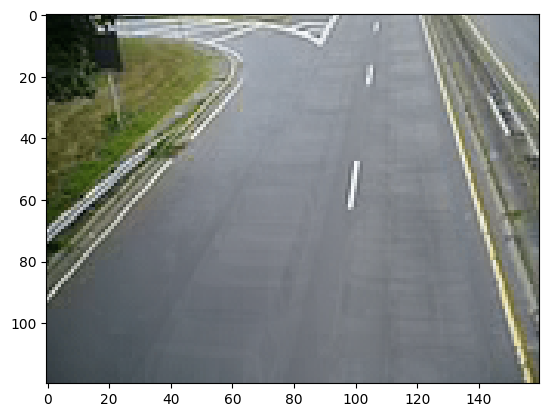

In [ ]:
# your code here
fa_background = np.mean(train_frames*255, axis=0).astype(np.uint8)
plt.imshow(fa_background)
plt.show()

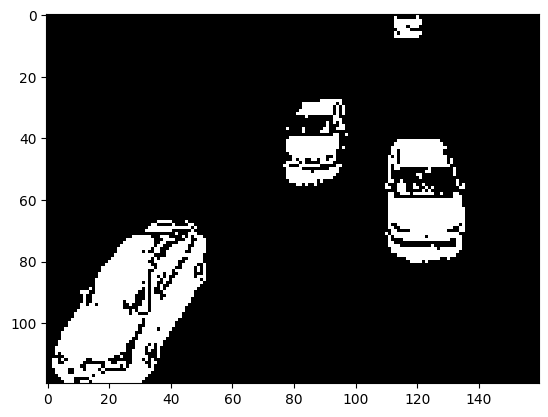

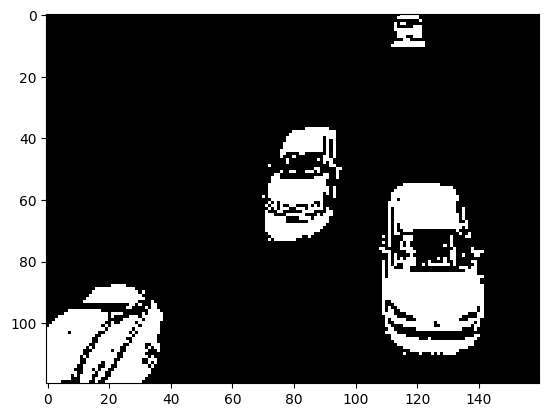

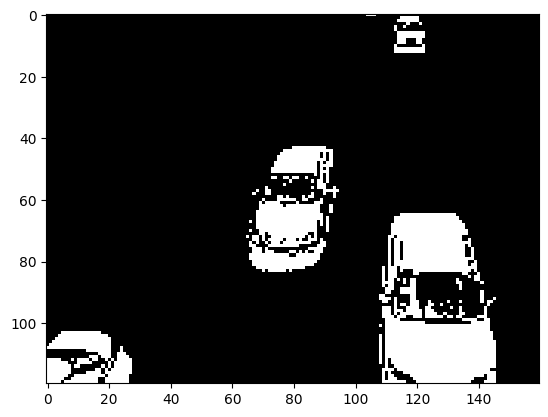

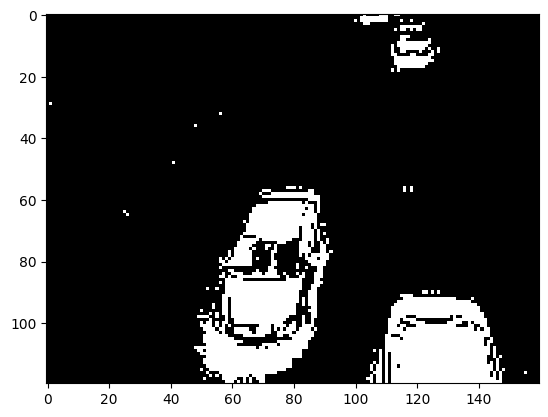

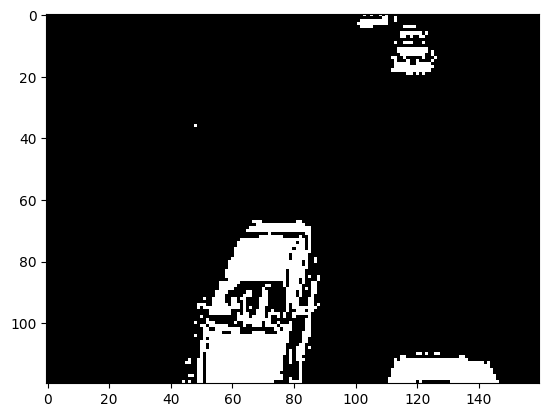

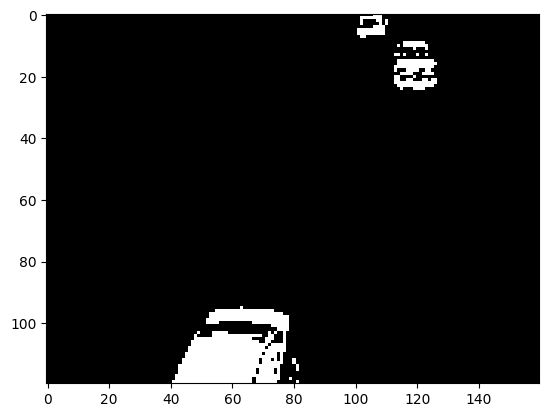

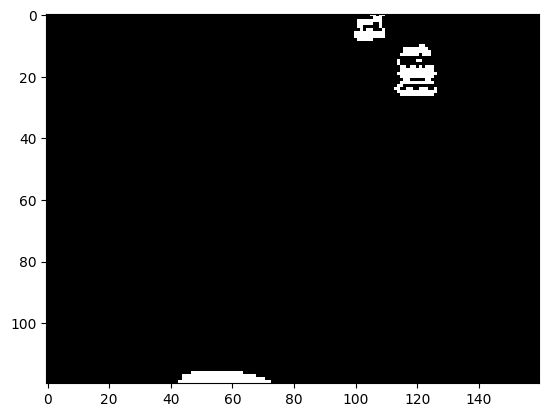

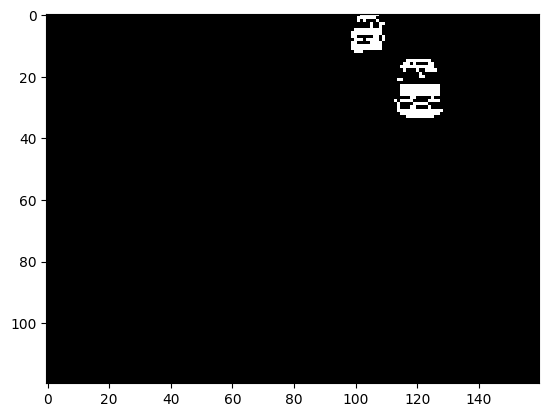

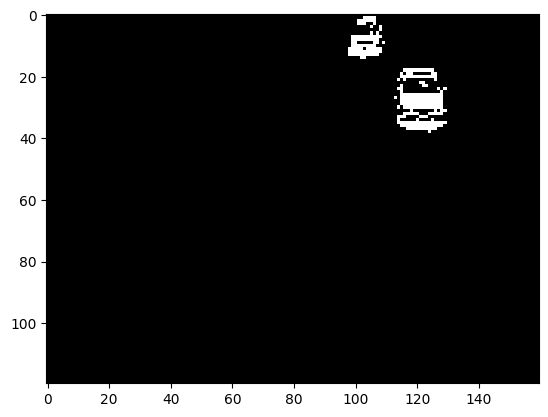

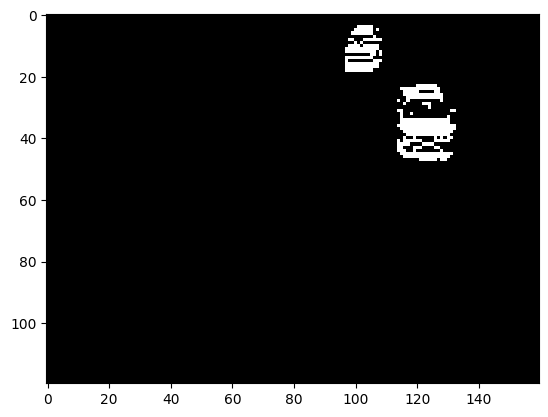

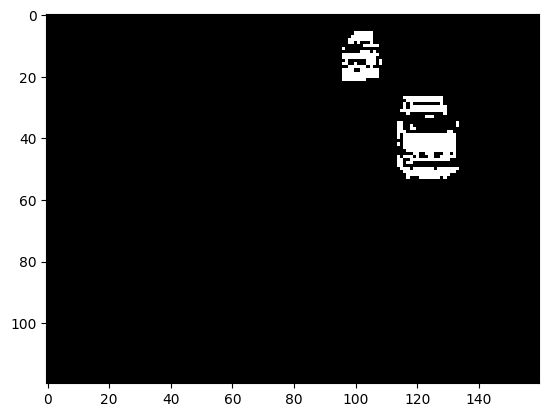

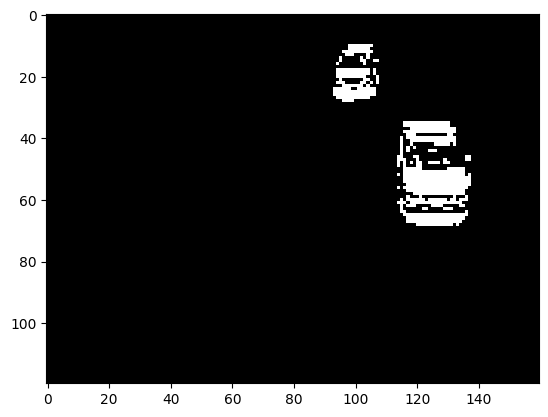

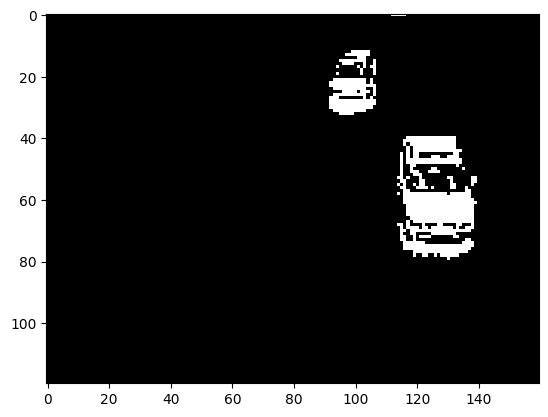

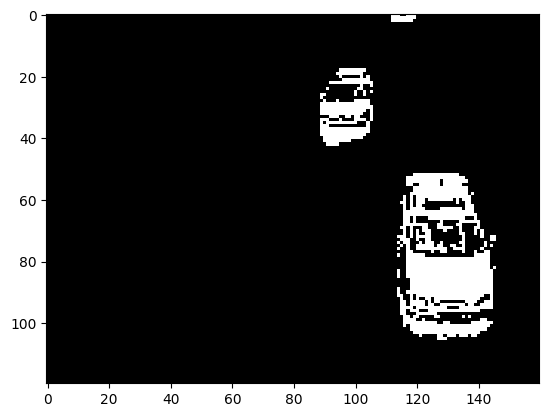

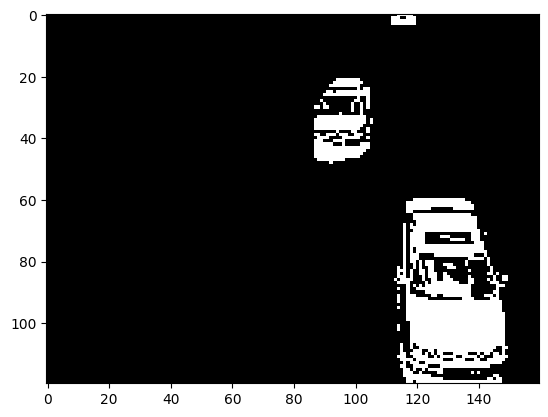

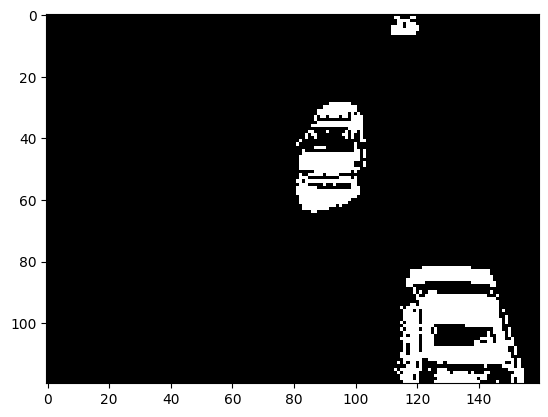

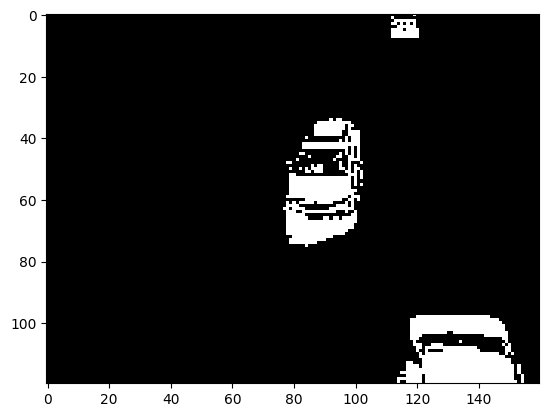

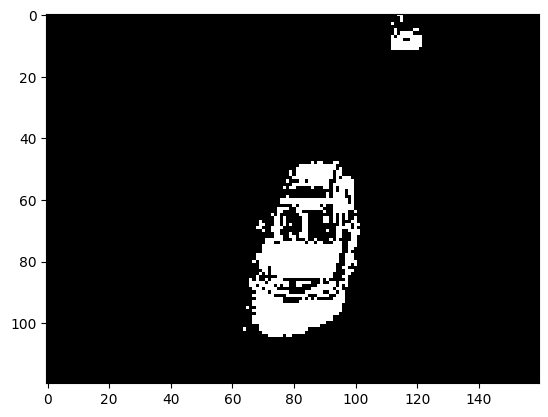

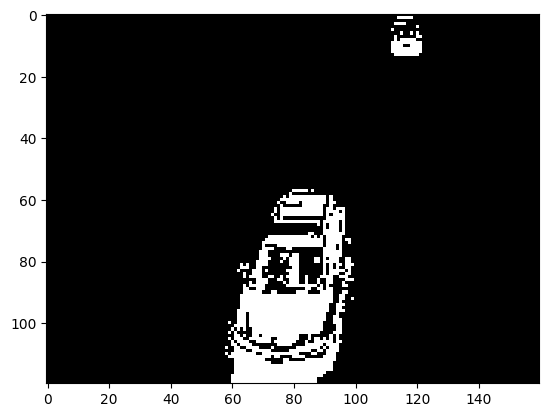

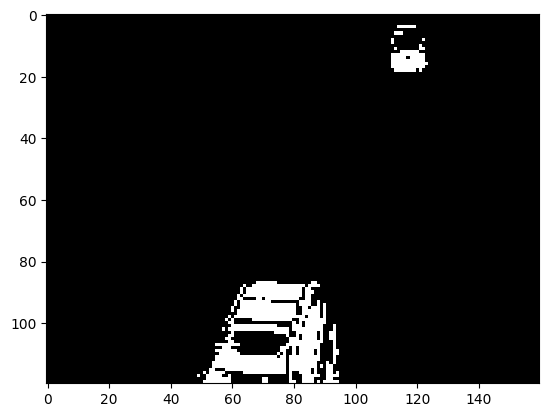

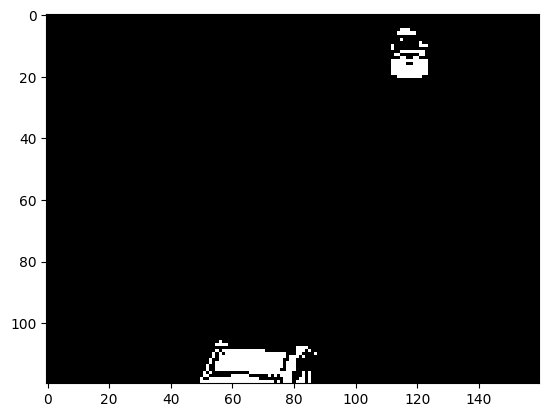

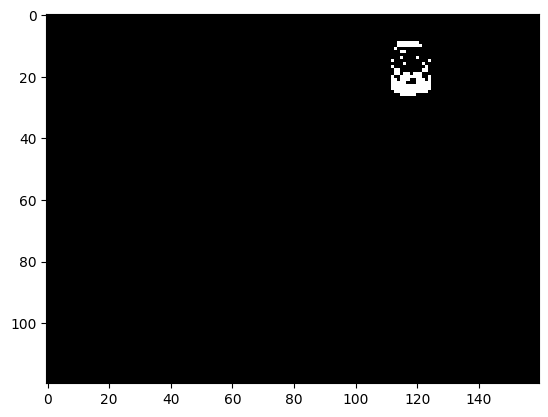

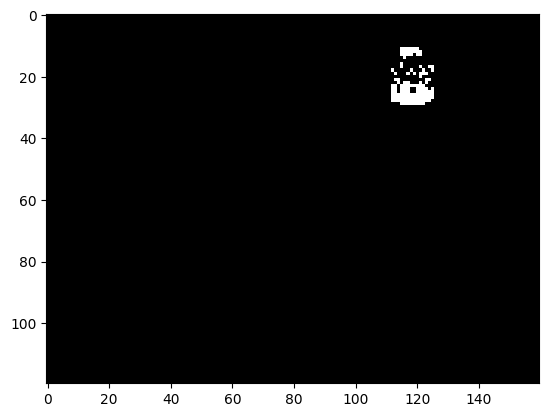

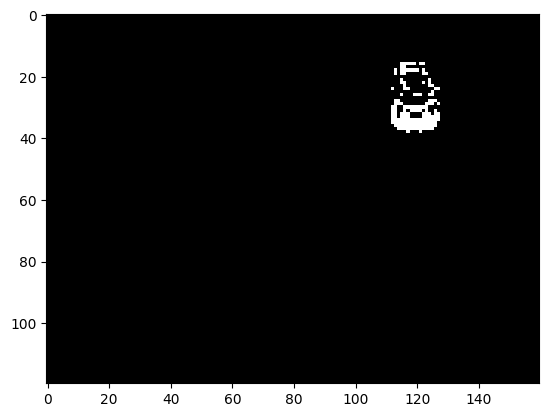

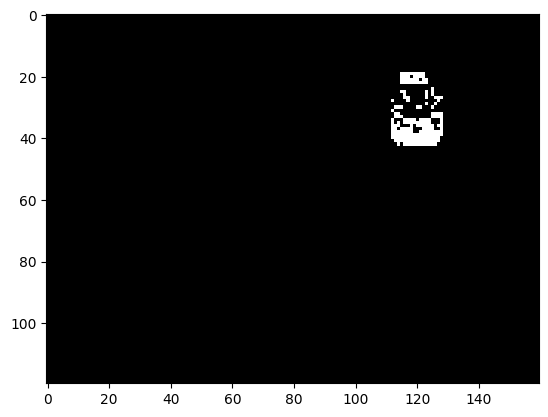

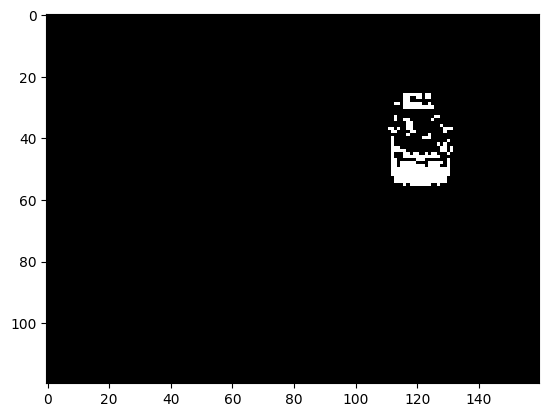

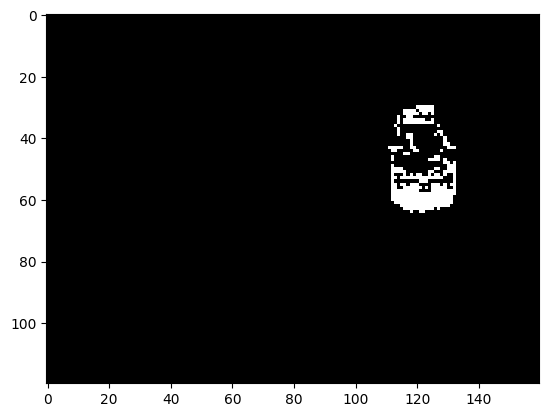

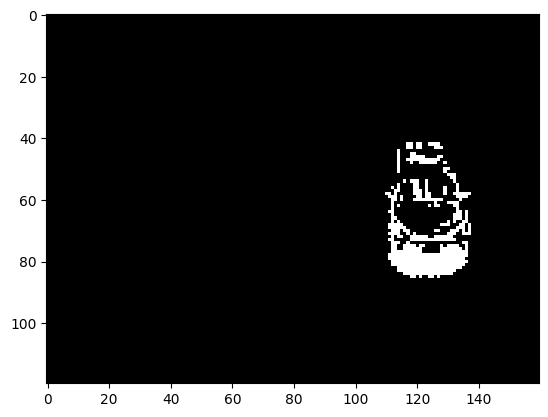

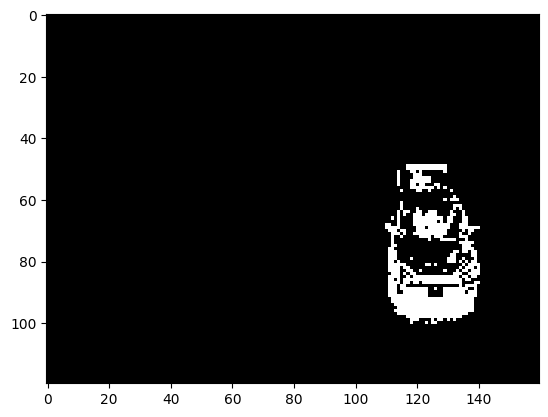

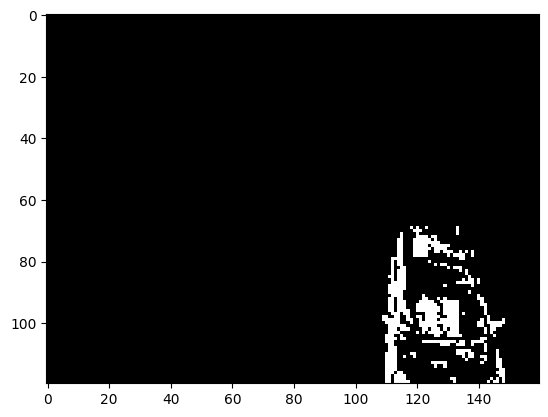

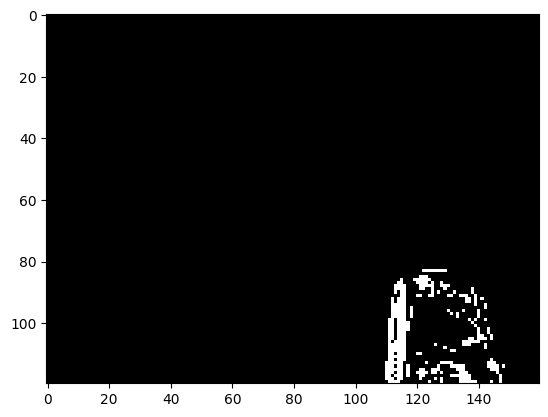

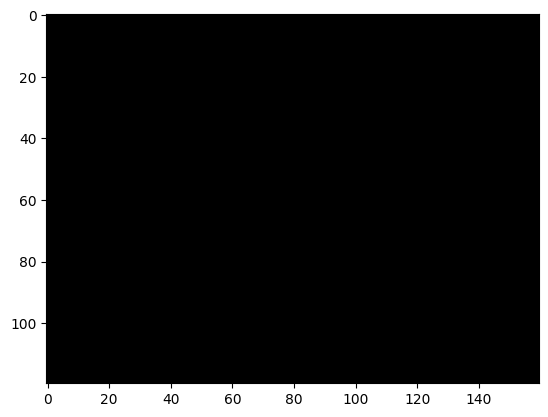

In [ ]:

for i in range(test_frames.shape[0]):
    foregrounds = np.abs(test_frames[i]*255 - fa_background)
    foregrounds = np.array(foregrounds,dtype='uint8')
    foregrounds = cv2.cvtColor(foregrounds, cv2.COLOR_BGR2GRAY)
    threshold = 50
    for i in range(foregrounds.shape[0]):
        for j in range(foregrounds.shape[1]):
            if foregrounds[i][j]<threshold:
                foregrounds[i][j]=0
            else:
                foregrounds[i][j]=255

    plt.imshow(foregrounds,cmap='gray')
    plt.show()

#### GMMs per pixel

Create Set of GMMs for every pixel and fit them considering every training frame

  1%|          | 1/120 [00:00<01:29,  1.33it/s]<ipython-input-3-bab37ed9bea7>:69: RuntimeWarning: invalid value encountered in divide
  self.means[c] = np.sum(X * self.ric[:, c][:, np.newaxis], axis=0) / clusterSum
<ipython-input-3-bab37ed9bea7>:72: RuntimeWarning: divide by zero encountered in divide
  self.covars[c] = (np.dot(self.ric[:, c] * diff.T, diff)/ clusterSum)
 62%|██████▎   | 75/120 [00:56<00:35,  1.25it/s]<ipython-input-3-bab37ed9bea7>:54: RuntimeWarning: invalid value encountered in divide
  self.ric[i] = self.ric[i]/np.sum(self.ric[i])
100%|██████████| 120/120 [01:37<00:00,  1.23it/s]
/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


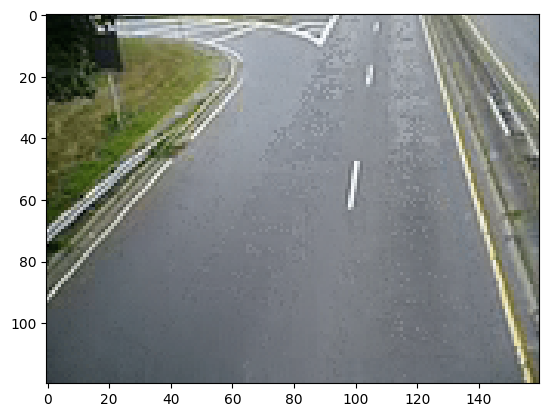

In [ ]:
# your code here


from tqdm import tqdm
from sklearn.mixture import GaussianMixture


gmm_background = np.zeros(shape = (train_frames.shape[1], train_frames.shape[2], 3))

for i in tqdm(range(train_frames.shape[1])):
    for j in range(train_frames.shape[2]):
        X = train_frames[:, i, j, :]
        X = X.reshape(X.shape[0], 3)

        gmm = GMM(2,max_iter=5)
        gmm.fit(X)
        means = gmm.means
        weights = gmm.weights
        idx = np.argmax(weights)
        gmm_background[i][j][:] = means[idx]




#### Extract Background Image from the trained model

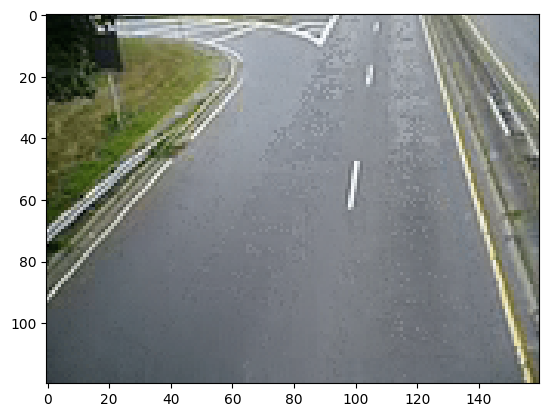

In [ ]:
plt.imshow(gmm_background)
plt.show()

### Outputs

You can use the helper functions given below to display and save frames as videos, feel free to change them accordingly.

In [ ]:
from google.colab.patches import cv2_imshow

def display_frames(frames, fps=10.0):
    """
    Display the frames as a video.
    """
    eps = 0.0001

    wait_time = int(1000 // fps)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        cv2_imshow(frame)
        k = cv2.waitKey(wait_time)

        if k == ord('q'):
            print("Quitting...")
            break




from google.colab.patches import cv2_imshow

def save_frames(frames, fps=10.0, output_path='/content/frames1/results', file_name='temp'):
    """
    Save the frames as a video.
    """
    eps = 0.0001

    frame_rate = float(fps)
    frame_size = (int(frames[0].shape[1]), int(frames[0].shape[0]))
    wait_time = int(1000 // fps)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    save_path = os.path.join(output_path, f"{file_name.rsplit('.', 1)[0]}.mp4")

    vid_wrt = cv2.VideoWriter(save_path, fourcc, frame_rate, frame_size)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        cv2_imshow(frame)
        vid_wrt.write(frame)

    vid_wrt.release()




#### Frame Averaging

In [ ]:

output_frames=[]
for i in range(frames.shape[0]):
    foregrounds = np.abs(frames[i]*255 - fa_background)
    foregrounds = np.array(foregrounds,dtype='uint8')
    foregrounds = cv2.cvtColor(foregrounds, cv2.COLOR_BGR2GRAY)
    threshold = 50
    for i in range(foregrounds.shape[0]):
        for j in range(foregrounds.shape[1]):
            if foregrounds[i][j]<threshold:
                foregrounds[i][j]=0
            else:
                foregrounds[i][j]=255
    output_frames.append(foregrounds)

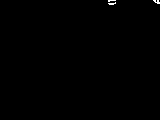

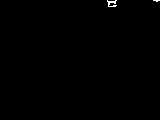

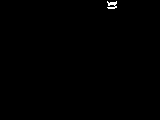

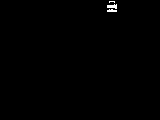

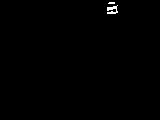

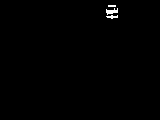

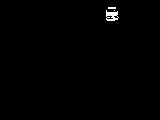

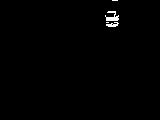

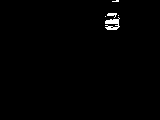

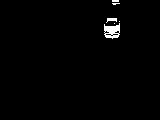

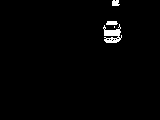

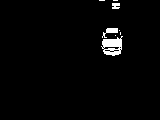

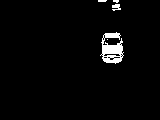

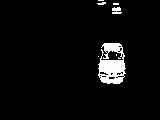

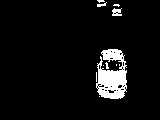

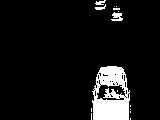

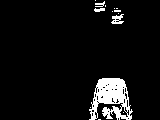

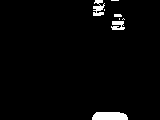

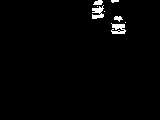

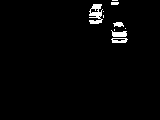

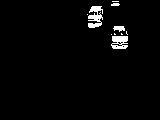

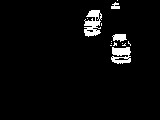

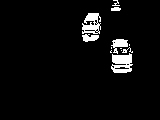

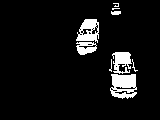

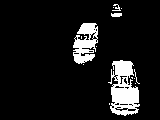

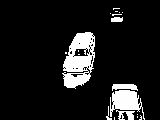

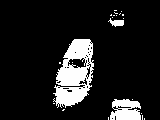

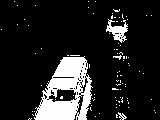

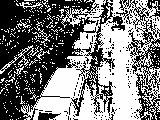

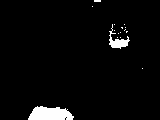

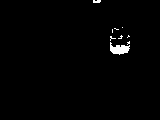

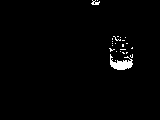

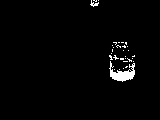

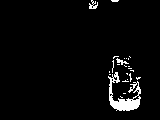

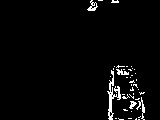

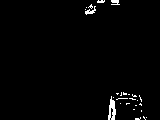

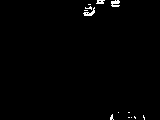

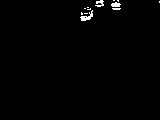

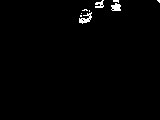

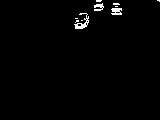

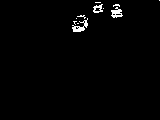

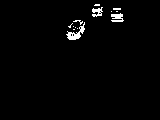

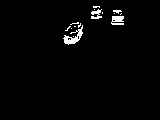

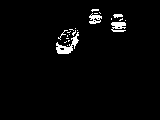

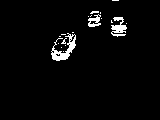

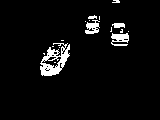

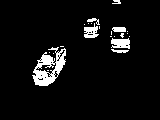

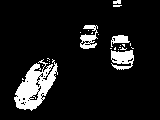

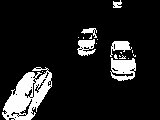

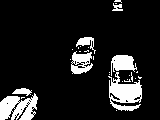

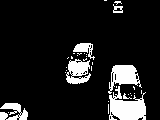

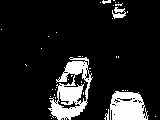

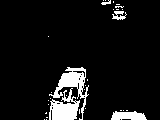

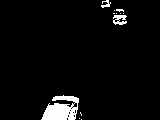

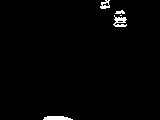

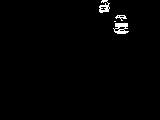

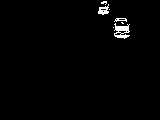

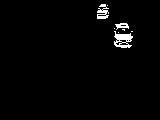

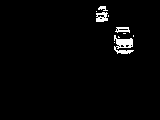

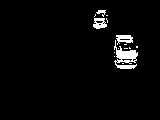

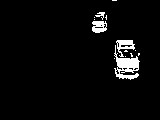

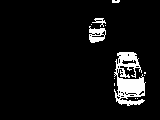

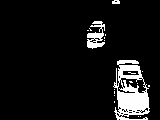

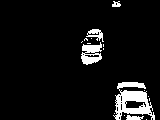

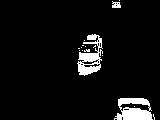

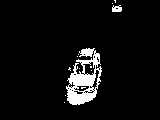

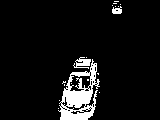

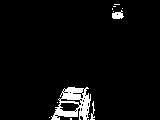

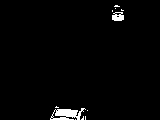

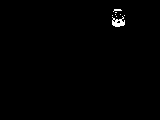

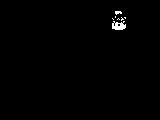

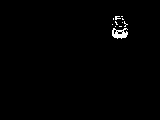

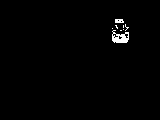

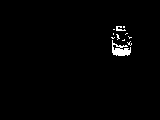

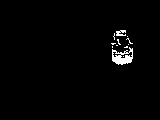

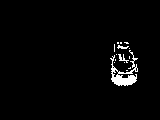

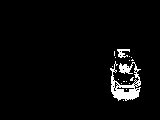

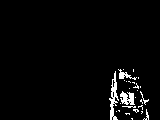

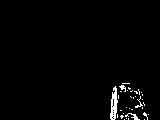

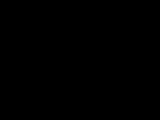

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
display_frames(output_frames)

#### GMMs per pixel

In [ ]:

output_frames=[]
for i in range(frames.shape[0]):
    foregrounds = np.abs(frames[i]*255 - gmm_background*255)
    foregrounds = np.array(foregrounds,dtype='uint8')
    foregrounds = cv2.cvtColor(foregrounds, cv2.COLOR_BGR2GRAY)
    threshold = 50
    for i in range(foregrounds.shape[0]):
        for j in range(foregrounds.shape[1]):
            if foregrounds[i][j]<threshold:
                foregrounds[i][j]=0
            else:
                foregrounds[i][j]=255
    output_frames.append(foregrounds)

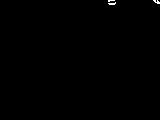

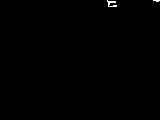

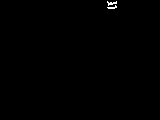

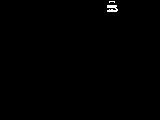

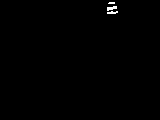

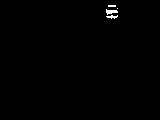

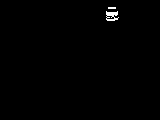

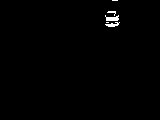

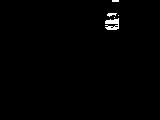

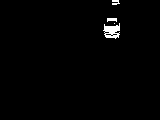

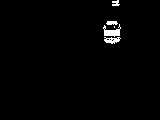

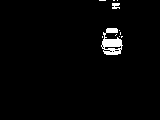

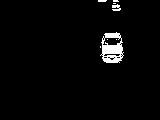

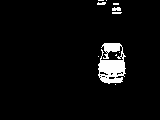

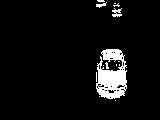

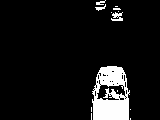

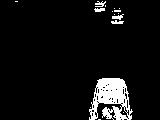

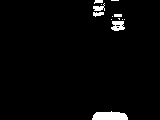

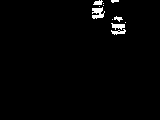

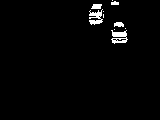

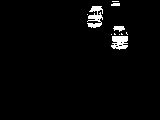

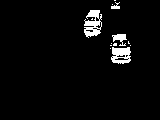

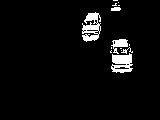

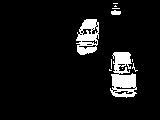

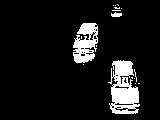

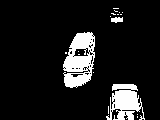

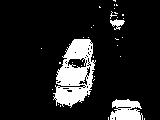

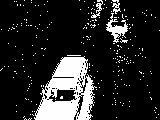

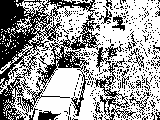

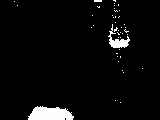

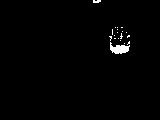

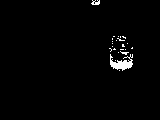

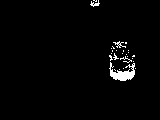

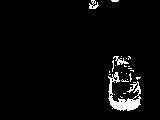

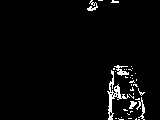

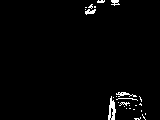

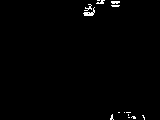

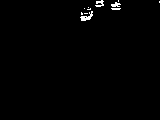

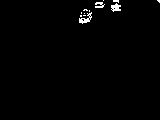

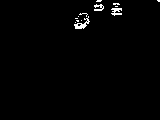

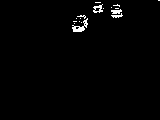

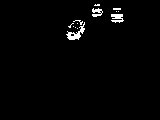

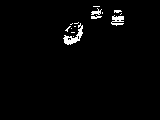

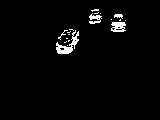

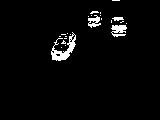

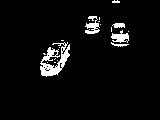

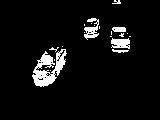

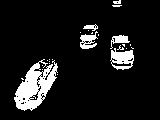

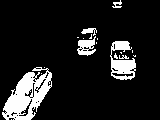

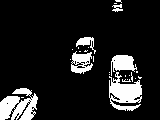

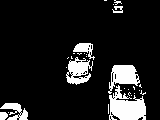

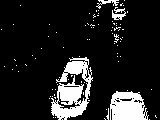

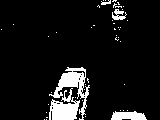

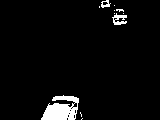

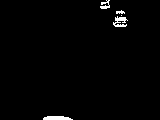

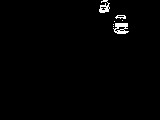

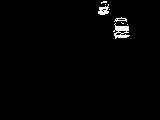

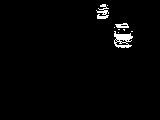

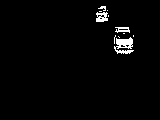

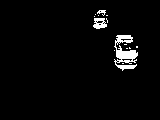

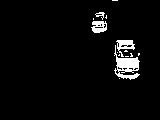

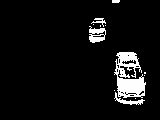

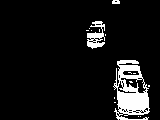

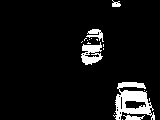

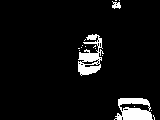

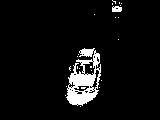

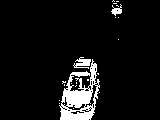

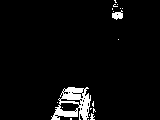

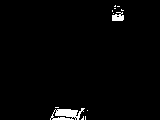

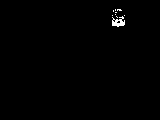

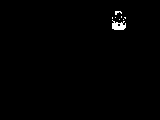

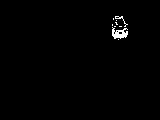

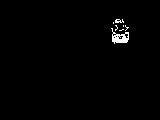

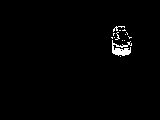

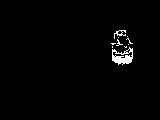

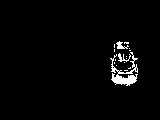

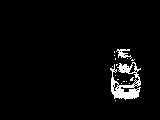

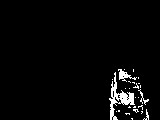

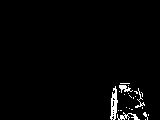

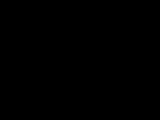

In [ ]:
display_frames(output_frames)